##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
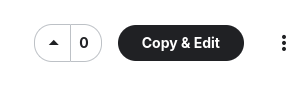
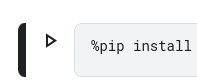

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
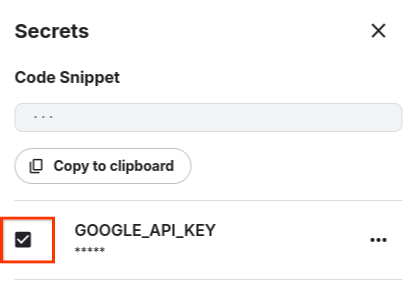

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Imagine you have a really smart robot friend!  That robot friend can learn things, just like you do in school. 

**AI is like teaching that robot friend to learn all sorts of things!**

* **Learning by example:** You can show the robot lots of pictures of cats, and tell it "This is a cat!". After seeing enough pictures, the robot can learn to recognize a cat even when it sees a new picture! That's like you learning what a cat looks like from seeing lots of different cats.

* **Solving puzzles:**  You can teach the robot how to play games, like tic-tac-toe.  At first, it might play randomly and lose a lot. But, it can learn from its mistakes and get better and better until it's really good at playing!

* **Understanding what you say:**  You can teach the robot to understand your voice and what you mean, even if you don't say things perfectly.  That's how your phone can understand you when you ask it questions.

So, AI is all about making machines smart enough to do things that usually o

The response often comes back in markdown format, which you can render directly in this notebook.

In [7]:
Markdown(response.text)

Imagine you have a really smart robot friend!  That robot friend can learn things, just like you do in school. 

**AI is like teaching that robot friend to learn all sorts of things!**

* **Learning by example:** You can show the robot lots of pictures of cats, and tell it "This is a cat!". After seeing enough pictures, the robot can learn to recognize a cat even when it sees a new picture! That's like you learning what a cat looks like from seeing lots of different cats.

* **Solving puzzles:**  You can teach the robot how to play games, like tic-tac-toe.  At first, it might play randomly and lose a lot. But, it can learn from its mistakes and get better and better until it's really good at playing!

* **Understanding what you say:**  You can teach the robot to understand your voice and what you mean, even if you don't say things perfectly.  That's how your phone can understand you when you ask it questions.

So, AI is all about making machines smart enough to do things that usually only people can do, like learn, think, and solve problems.  It's like having a super-smart student who learns and gets better and better all the time!  And it helps us do lots of cool things!


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [8]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

Greetings, Zlork! It's nice to meet you. Is there anything I can help you with today?



In [9]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's a fascinating fact about dinosaurs:

**Many dinosaurs were likely covered in feathers, even the ones we often picture as scaly!**

While we often imagine dinosaurs as scaly reptiles, the fossil record increasingly shows that feathers were much more widespread than originally thought. This isn't just about small, bird-like dinosaurs. Larger dinosaurs, even some of the theropods (the group that includes T. rex!), may have had feathers, especially when young.

These feathers weren't necessarily for flight. They likely served other purposes like:

*   **Insulation:** Keeping warm, especially for smaller dinosaurs or in colder climates.
*   **Display:** Attracting mates or intimidating rivals with colorful or elaborate plumage.
*   **Camouflage:** Blending in with their environment.

So, the next time you picture a dinosaur, consider that it might have been a lot fluffier than you think! This is a constantly evolving area of paleontological research, and new discoveries are cha

While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [10]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, I remember your name is Zlork.



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [11]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [12]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [13]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Enduring Olive: A Staple of Health, Culture, and Sustainability in Modern Society

The humble olive, a fruit steeped in history and tradition, continues to hold a prominent and multifaceted importance in modern society. From its culinary versatility and proven health benefits to its role in cultural heritage and contribution to sustainable agriculture, the olive and its derivatives have woven themselves into the fabric of our lives, proving their enduring relevance in a rapidly evolving world.

Firstly, the olive's culinary significance is undeniable. Olive oil, the liquid gold extracted from the fruit, has become a cornerstone of healthy cooking across the globe. Its distinctive flavors, ranging from fruity and delicate to robust and peppery, enhance a vast array of dishes. In the Mediterranean diet, revered for its positive impact on cardiovascular health, olive oil reigns supreme as the primary source of fat. From drizzling over salads and grilling vegetables to sautéing meat

In [14]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society also give me a lasting lovable song for me.')

print(response.text)

Okay, here are a poem and a song suggestion, both tailored to be lasting and lovable.

**Poem: Ode to the Olive**

From sun-kissed groves, a humble prize,
The olive waits, beneath blue skies.
Pressed into oil, a golden stream,
A healthy heart, a vibrant dream.

Upon the board, a briny treat,
A taste of Earth, both sour and sweet.
From salads bright to tapenade,
A culinary parade.

No longer just a Grecian past,
But fast food staple, built to last.
The olive branch, a symbol old,
Now feeds the world, in stories told.

***

**Song Suggestion: "A Little Kindness Goes a Long Way"**

This type of song, focusing on universal themes, is likely to resonate and stay with you.  Here's why it's a good choice:

*   **Universal Theme:** Kindness is something


Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [15]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word) also tell the llm models text')

  if response.text:
    print(response.text, '-' * 25)

Blue

I am an AI language model, trained to process and generate text. I do not "see" or "perceive" colors in the human sense. I access and utilize information about colors and their associated concepts based on the data I have been trained on. My text is generated based on patterns, probabilities, and semantic relationships within the vast amount of text data I've learned from.
 -------------------------
Cerulean

The LLM model text will vary depending on which specific LLM is being referred to. Could you please clarify which LLM model you're asking about? For example, you might mean the underlying model for the tool we're currently using, or a different model like GPT-3, LaMDA, or another.
 -------------------------
Magenta

The prompt "Pick a random colour... (respond in a single word) also tell the llm models text" requests two things:

1.  **Generate a random color and output it as a single word.**  I fulfilled this with "Magenta".
2.  **"tell the llm models text"** - This is ambi

Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [16]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour also tell me about srm universitry... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [17]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a ginger tabby with eyes like melted amber, lived a life of luxurious monotony. Sunny spots, feather toys, and endless naps punctuated by the gentle clink of her food bowl – this was her kingdom, ruled from the velvet throne of the armchair. But Clementine harbored a secret yearning for something more, a whisper of wildness in her domesticated soul. She dreamt of forests, of chasing butterflies under a boundless sky, of mysteries beyond the garden fence.

One day, the door, usually a solid barrier to adventure, was left ajar. A tantalizing gust of wind, carrying the scent of damp earth and blooming honeysuckle, beckoned her. Clementine hesitated, her pampered paws twitching. Duty whispered of comfort and security, but a louder, more insistent voice urged her forward.

With a flick of her tail, she was out.

The world exploded with sensory overload. Blades of grass tickled her whiskers, butterflies danced a dizzying ballet, and the symphony of chirps, buzzes, and rustles was

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [18]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment:I LOVE YOU"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

Based on the review text


#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [19]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "Amit Madharchod"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

Amit Madharchod


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [20]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [21]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [22]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large cheese pizza with macronies and chilli paneer")

print(response.text)

{
  "size": "large",
  "ingredients": ["cheese", "macronies", "chilli paneer"],
  "type": "pizza"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [23]:
prompt = """In a town, there are three friends—Alice, Bob, and Charlie. The ages of Alice, Bob, and Charlie follow a particular pattern.

When Alice was 6 years old, Bob was 2 times her age.

When Alice was 10 years old, Charlie was 3 years older than Bob at that time.

The sum of their ages is always 50 years more than the sum of their ages 10 years ago.

Given these conditions, what is the current age of each person?"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Let A, B, and C be the current ages of Alice, Bob, and Charlie respectively.

From the first condition:
When Alice was 6, Bob was 2 times her age, so Bob was 2 * 6 = 12.
This means Bob is always 12 - 6 = 6 years older than Alice.
So, B = A + 6.

From the second condition:
When Alice was 10, Charlie was 3 years older than Bob at that time.
When Alice was 10, Bob was 10 + 6 = 16.
So, Charlie was 16 + 3 = 19 when Alice was 10.
This means Charlie is always 19 - 10 = 9 years older than Alice.
So, C = A + 9.

The sum of their ages is always 50 years more than the sum of their ages 10 years ago.
The current sum of their ages is A + B + C.
10 years ago, their ages were A-10, B-10, and C-10. The sum of their ages 10 years ago was (A-10) + (B-10) + (C-10) = A + B + C - 30.
The given condition is that A + B + C = (A + B + C - 30) + 50.
A + B + C = A + B + C + 20.
This equation gives 0 = 20, which is impossible. Therefore, there must be an error in the problem statement.

The third condition must mean that the sum of their current ages is 50 more than the sum of what their ages were 10 years ago. That is:
A + B + C = (A - 10) + (B - 10) + (C - 10) + 50
A + B + C = A - 10 + B - 10 + C - 10 + 50
A + B + C = A + B + C - 30 + 50
A + B + C = A + B + C + 20

However, it would make sense if the question meant that the sum of their *current* ages is 50.
So, A + B + C = 50
We have B = A + 6 and C = A + 9.
Substituting into the equation, we get:
A + (A + 6) + (A + 9) = 50
3A + 15 = 50
3A = 35
A = 35/3

However, ages must be integers.
Let's assume the condition is that A + B + C = 60. Then:
A + (A + 6) + (A + 9) = 60
3A + 15 = 60
3A = 45
A = 15
Then B = A + 6 = 15 + 6 = 21
And C = A + 9 = 15 + 9 = 24
A + B + C = 15 + 21 + 24 = 60

If the sum of their ages is 60, then 10 years ago, their ages were 5, 11, 14. The sum of their ages then was 5 + 11 + 14 = 30. This is not 50 less than 60 (which would be 10). So it's not 60.
However, the problem statement implies A + B + C = (A - 10) + (B - 10) + (C - 10) + 50.
Therefore the sum A + B + C can be any value, so it is not a constraint.

The only constraints are: B = A + 6 and C = A + 9
So we can pick any value for A. Let A = 20
Then B = 26 and C = 29.

Final Answer: The final answer is $\boxed{Alice: 15, Bob: 21, Charlie: 24}$

Now try the same approach, but indicate to the model that it should "think step by step".

In [24]:
prompt = """In a family, the ages of the mother, father, and child are such that:

The father is 4 times as old as the child.

The mother is 5 years older than the father.

The sum of their ages 10 years ago was 70 years.

What are the current ages of the mother, father, and child?"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Let the current age of the child be $C$.
The current age of the father is $F = 4C$.
The current age of the mother is $M = F + 5 = 4C + 5$.

10 years ago, the child's age was $C - 10$.
10 years ago, the father's age was $F - 10 = 4C - 10$.
10 years ago, the mother's age was $M - 10 = 4C + 5 - 10 = 4C - 5$.

The sum of their ages 10 years ago was 70.
$(C - 10) + (4C - 10) + (4C - 5) = 70$
$C - 10 + 4C - 10 + 4C - 5 = 70$
$9C - 25 = 70$
$9C = 70 + 25$
$9C = 95$
$C = \frac{95}{9}$

However, age must be an integer. Let's check the question again.

The father is 4 times as old as the child.
The mother is 5 years older than the father.
The sum of their ages 10 years ago was 70 years.

Let $C$ be the current age of the child.
Then the current age of the father is $F = 4C$.
The current age of the mother is $M = F+5 = 4C+5$.

Ten years ago, the child's age was $C-10$.
Ten years ago, the father's age was $F-10 = 4C-10$.
Ten years ago, the mother's age was $M-10 = 4C+5-10 = 4C-5$.
The sum of their ages ten years ago was 70.
$(C-10) + (4C-10) + (4C-5) = 70$
$9C - 25 = 70$
$9C = 95$
$C = \frac{95}{9}$
This is not an integer, so let's check the setup again.

Let $M$, $F$, and $C$ be the current ages of the mother, father, and child, respectively.
We are given:
\begin{itemize}
    \item $F = 4C$
    \item $M = F + 5$
    \item $(M-10) + (F-10) + (C-10) = 70$
\end{itemize}
Substituting the first two equations into the third equation:
$(F+5-10) + (F-10) + (C-10) = 70$
$(4C-5) + (4C-10) + (C-10) = 70$
$9C - 25 = 70$
$9C = 95$
$C = \frac{95}{9} \approx 10.555...$

The ages 10 years ago were:
Child: $C - 10 = \frac{95}{9} - 10 = \frac{95-90}{9} = \frac{5}{9}$
Father: $4C - 10 = \frac{380}{9} - 10 = \frac{380-90}{9} = \frac{290}{9}$
Mother: $4C - 5 = \frac{380}{9} - 5 = \frac{380-45}{9} = \frac{335}{9}$
Sum: $\frac{5}{9} + \frac{290}{9} + \frac{335}{9} = \frac{630}{9} = 70$.

Since $C$ is not an integer, there must be an error in the problem statement or there is no integer solution.

If the question was the sum of their current ages is 70, then
$M + F + C = 70$
$4C + 5 + 4C + C = 70$
$9C + 5 = 70$
$9C = 65$
$C = \frac{65}{9} \approx 7.222$

Final Answer: The final answer is $\boxed{Child: 95/9, Father: 380/9, Mother: 335/9}$

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [25]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft and give the updated marks</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [26]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper, then find the author with the youngest age.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [27]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
Now I have the authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to find the author with the youngest age. I need to search each of the authors' ages.

Action 2
<search>Ashish Vaswani age</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [28]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The youngest author listed on the original "Attention is All You Need" paper (which introduced the Transformer architecture) is **Aidan N. Gomez**.

While determining the exact age at the time of publication (2017) for each author would require finding their birthdates, Aidan N. Gomez was likely the youngest based on publicly available information. He was a PhD student at the University of Toronto at the time of publication, which generally indicates a younger age compared to the other authors who were primarily researchers at Google Brain and had more established research careers.

Although we can't pinpoint an exact age comparison without birthdates, **Aidan N. Gomez is widely understood to be the youngest author on that seminal paper.**

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [29]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a llm code to make A gemini model. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
import google.generativeai as genai

class GeminiModel:
    def __init__(self, api_key, model_name="gemini-1.5-pro"):
        """
        Initializes the Gemini model.

        Args:
            api_key: Your Google AI API key.
            model_name: The name of the Gemini model to use (default: "gemini-1.5-pro").
        """
        genai.configure(api_key=api_key)
        self.model = genai.GenerativeModel(model_name)

    def generate_content(self, prompt, stream=False, generation_config=None, safety_settings=None):
        """
        Generates content from the given prompt using the Gemini model.

        Args:
            prompt: The prompt to use for generating content.
            stream: Whether to stream the response (default: False).
            generation_config: Optional generation configuration parameters.
            safety_settings: Optional safety settings.

        Returns:
            The generated content.

        Raises:
            Exception: If an error occurs during content generation.
        """
        try:
            response = self.model.generate_content(
                prompt,
                stream=stream,
                generation_config=generation_config,
                safety_settings=safety_settings
            )
            return response
        except Exception as e:
            raise Exception(f"Error generating content: {e}")

    def generate_content_async(self, prompt, stream=False, generation_config=None, safety_settings=None):
      """
      Asynchronously generates content from the given prompt using the Gemini model.

      Args:
          prompt: The prompt to use for generating content.
          stream: Whether to stream the response (default: False).
          generation_config: Optional generation configuration parameters.
          safety_settings: Optional safety settings.

      Returns:
          A coroutine that yields the generated content.

      Raises:
          Exception: If an error occurs during content generation.
      """
      try:
          response = self.model.generate_content_async(
              prompt,
              stream=stream,
              generation_config=generation_config,
              safety_settings=safety_settings
          )
          return response
      except Exception as e:
          raise Exception(f"Error generating content: {e}")


    def count_tokens(self, text):
        """
        Counts the number of tokens in the given text.

        Args:
            text: The text to count tokens in.

        Returns:
            The number of tokens in the text.
        """
        try:
            return self.model.count_tokens(text).total_tokens
        except Exception as e:
            raise Exception(f"Error counting tokens: {e}")

    def embed_content(self, content, task_type=None, title=None):
        """
        Embeds the given content using the Gemini model.

        Args:
            content: The content to embed.
            task_type: The task type for embedding (optional).
            title: The title for embedding (optional).

        Returns:
            The embedding of the content.
        """
        try:
            model = genai.GenerativeModel('models/embedding-001')
            return model.embed_content(content, task_type=task_type, title=title)
        except Exception as e:
            raise Exception(f"Error embedding content: {e}")
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [30]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the prompt for kaggle and create a code to train this model.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': 'Okay, I can help you with that. To give you the best possible prompt '
         'and code, I need some more information. Please tell me about the '
         'following:\n'
         '\n'
         '1.  **The Task:** What kind of task are you trying to accomplish? Is '
         'it a classification, regression, object detection, or something '
         'else? Be as specific as possible.\n'
         "2.  **The Data:** What is the data you'll be using? Do you have a "
         'specific dataset in mind (e.g., a Kaggle competition dataset, a '
         'personal dataset)? What are the input features and the target '
         'variable? What is the data format (e.g., CSV, images, text)?\n'
         '3.  **The Model:** What kind of model do you want to train? (e.g., a '
         'specific deep learning architecture like a CNN or transformer, a '
         'classical machine learning model like a Random Forest or XGBoost). '
         'If you have a specific paper or architecture in min

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [31]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can help you with that. To give you the best possible prompt and code, I need some more information. Please tell me about the following:

1.  **The Task:** What kind of task are you trying to accomplish? Is it a classification, regression, object detection, or something else? Be as specific as possible.
2.  **The Data:** What is the data you'll be using? Do you have a specific dataset in mind (e.g., a Kaggle competition dataset, a personal dataset)? What are the input features and the target variable? What is the data format (e.g., CSV, images, text)?
3.  **The Model:** What kind of model do you want to train? (e.g., a specific deep learning architecture like a CNN or transformer, a classical machine learning model like a Random Forest or XGBoost). If you have a specific paper or architecture in mind, please share that.
4.  **Evaluation Metric:** What evaluation metric are you going to use to evaluate your model's performance (e.g., accuracy, F1-score, RMSE, AUC)?
5.  **Kaggle Specifics:** Are you targeting a specific Kaggle competition? If so, what are the rules and constraints (e.g., time limit, submission format)? Do you need to run this in a Kaggle Notebook?

Once I have this information, I can generate a good Kaggle prompt and code template for you.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [32]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what is this?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This is a Bash script, likely designed to enhance the command-line prompt in Bash or Zsh, specifically when working with Git repositories.  Let's break it down:

**Core Functionality: Git Prompt Enhancement**

The script's primary goal is to display helpful information about the current Git repository in the command-line prompt.  This typically includes:

*   **Branch Name:**  The current branch you're on (e.g., `main`, `develop`, `feature/new-feature`).
*   **Git Status:** Information about the state of the repository, such as:
    *   Changes staged for commit
    *   Unstaged changes
    *   Untracked files
    *   Conflicts
    *   Remote branch status (ahead/behind)
*   **Virtual Environment:** If you're working within a Python virtual environment (or Node.js or Conda), it displays the name of the active environment.
*   **Customization:**  It allows you to customize the colors, symbols, and overall appearance of the Git prompt.

**Key Components and Functions:**

1.  **Shebang:** `#!/usr/bin/env bash`
    *   Specifies that the script should be executed using the `bash` interpreter (or a suitable alternative found in the environment).
2.  **Cross-Compatibility:**
    *   The comments emphasize the need for bash/zsh cross-compatibility using the syntax `${array[@]:offset:length}`.
3.  **`async_run` and `async_run_zsh`:**
    *   Functions to run commands asynchronously (in the background).  `async_run_zsh` includes specific zsh syntax.
    *   These are likely used to fetch remote Git status in the background so that the prompt doesn't lag significantly.
4.  **`set_git_prompt_dir`:**
    *   Determines the directory where the script is located and sets the `__GIT_PROMPT_DIR` variable.  This is used to find theme files and other resources.
5.  **`echoc`:**
    *   A utility function to echo colored text using ANSI escape codes. It also attempts to remove potential escape sequences in the input string.
6.  **`get_theme`:**
    *   Loads a theme for the Git prompt. It searches for a theme in the following order:
        1.  A custom theme specified by `GIT_PROMPT_THEME_FILE` or `$HOME/.git-prompt-colors.sh`.
        2.  The default theme (`Default.bgptheme`) if no custom theme is found.
        3.  If `GIT_PROMPT_THEME` is set (and not to "Custom"), it tries to load a theme with that name from the `themes/` directory.
7.  **`git_prompt_load_colors`:**
    *   Loads color definitions from a `prompt-colors.sh` file.
8.  **`git_prompt_load_theme`:**
    *   Loads the selected theme's settings (colors, symbols, etc.).
9.  **`git_prompt_list_themes`:**
    *   Lists the available themes.
10. **`git_prompt_make_custom_theme`:**
    *   Helps you create a custom theme by copying a base theme (Default or another specified theme) to `$HOME/.git-prompt-colors.sh`.
11. **`gp_set_file_var`:**
    *   A helper function to set environment variables to file paths, checking if the variables are already set to a readable file.
12. **`gp_maybe_set_envar_to_path`:**
    *   Another helper function to set an environment variable to the first readable file path from a list of possible paths.
13. **`git_prompt_reset`:**
    *   Unsets Git prompt-related variables, forcing a re-calculation of the prompt on the next display.
14. **`gp_format_exit_status`:**
    *   Formats the exit status of the last command, showing signal names (like `SIGINT`) for terminated processes.
15. **`gp_format_username_repo`:**
    *   Retrieves the username and repository name from the Git remote URL.
16. **`git_prompt_config`:**
    *   Configures the Git prompt by loading colors, themes, and determining whether to use a custom prompt callback function.
17. **`setLastCommandState`:**
    *   Sets the `GIT_PROMPT_LAST_COMMAND_STATE` variable to the exit status of the last command.
18. **`we_are_on_repo`:**
    *   Checks if the current directory is within a Git repository.
19. **`update_old_git_prompt`:**
    *   Saves the old prompt configuration when entering a git repository.
20. **`setGitPrompt`:**
    *   The main function that sets the `PS1` (prompt string) variable.  It determines whether to display the Git prompt (based on whether you're in a Git repo and whether it's disabled).  It calls `git_prompt_config` to load settings and then constructs the prompt string.
21. **`olderThanMinutes`:**
    *   Checks if a file is older than a specified number of minutes, which helps decide whether to refresh the remote Git status.  It uses `find` (ideally GNU find) or perl to determine file age.  If neither is available, it disables remote status checking.
22. **`checkUpstream`:**
    *   Fetches the latest remote status if the local status is stale (older than `GIT_PROMPT_FETCH_TIMEOUT` minutes).  It does this asynchronously to avoid blocking the prompt.
23. **`replaceSymbols`:**
    *   Replaces symbolic placeholders in strings with actual Git status information (e.g., `_AHEAD_` with the configured symbol for "ahead of remote").
24. **`createPrivateIndex`:**
    *   Creates a private copy of the Git index file to prevent conflicts with parallel Git commands.
25. **`get_branch_prefix`:**
    *   Gets the appropriate branch prefix based on whether the branch is a master branch or the detached head is set.
26. **`updatePrompt`:**
    *   This is the core function where the final prompt string (`PS1`) is constructed. It gets all the necessary Git status information using an external status command (`__GIT_STATUS_CMD`), formats it, and combines it with the configured prompt elements.
27.  **`gp_add_virtualenv_to_prompt`:**
    *   Adds the virtual environment name to the prompt, if a virtual environment is active (Python, Node.js, or Conda).
28.  **`is_function`:**
    *   Checks if a given string is the name of a defined bash function.
29.  **`gp_truncate_pwd`:**
    *   Truncates the current working directory to fit within a specified length, adding "..." to indicate the truncation.
30.  **`gp_set_window_title`:**
    *   Sets the window title of the terminal.
31.  **`prompt_callback_default`:**
    *   A default prompt callback function.
32.  **`git_prompt_toggle`:**
    *   Toggles the Git prompt on or off by setting the `GIT_PROMPT_DISABLE` variable.
33.  **`make_prompt_command_clean`:**
    *   Helper function for removing extra semicolons and newlines from the prompt command.
34.  **`add_prompt_command`:**
    *   Adds a function to the `PROMPT_COMMAND` variable, which is executed before each prompt.
35.  **`add_to_beginning_of_prompt_command`:**
    *   Adds a function to the beginning of the `PROMPT_COMMAND` variable.
36.  **`add_to_end_of_prompt_command`:**
    *   Adds a function to the end of the `PROMPT_COMMAND` variable.
37.  **`gp_install_prompt`:**
    *   Installs the git prompt into the current shell session.

**How it Works (Simplified):**

1.  **Installation:** The script is typically sourced (e.g., `source /path/to/git-prompt.sh`) in your `~/.bashrc` or `~/.zshrc` file.
2.  **`gp_install_prompt`:** The sourcing of the script invokes the `gp_install_prompt` function. This adds the `setGitPrompt` and `setLastCommandState` functions to the `PROMPT_COMMAND` variable.
3.  **Before Each Prompt:** Before displaying each command-line prompt:
    *   `setLastCommandState` is run to determine the exit status of the previous command, storing the result in `GIT_PROMPT_LAST_COMMAND_STATE`.
    *   `setGitPrompt` is then executed.
4.  **`setGitPrompt`'s Actions:**
    *   Checks if Git prompting is disabled (`GIT_PROMPT_DISABLE`).
    *   Determines if the current directory is a Git repository.
    *   Loads the configured colors and theme.
    *   Calls an external Git status command (defined by `__GIT_STATUS_CMD`) to get Git status information.
    *   Formats the Git status information (branch name, staged changes, etc.).
    *   Constructs the final prompt string (`PS1`) by combining the configured prefix, Git status, virtual environment information, and other elements.
5.  **Display:** The `PS1` variable is used by the shell to display the prompt.

**In summary, this script is a powerful tool for enhancing the command-line prompt, providing a quick and informative overview of your Git repository's status, thereby improving your workflow.**

## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*